In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import random
from numba import jit
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.metrics import mean_squared_error
from jupyterthemes import jtplot
jtplot.style()

In [2]:
class ising:
    
    def __init__(self,J):
        self.J = J
        self.n = self.J.shape[0]
        self.X = np.random.choice([-1,1],self.n)
        self.S = np.zeros((self.n,self.n))
        self.counts = 0
        self.correl_counts = 0
    
    def update(self):
        self.counts += 1
        i = np.random.randint(0,self.n)
        E = self.X@self.J@self.X
        self.X[i] *= -1
        E_new = self.X@self.J@self.X
        dE = E_new - E
        p = 0.5*(1.0 + np.tanh(E_new-E))
        if np.random.uniform(0,1)>p:
            self.X[i] *= -1
            
        if self.counts%self.n ==0:
            self.correl_counts += 1
            self.S += np.outer(self.X,self.X)   
            
    def getCorrels(self):
        return self.S/self.correl_counts
    

In [3]:
''' a matrix of random uniform connections J[ij], where 
    J[ij] = 0  w.p. 0.4
    J[ij] = random.uniform() w.p. 0.6
    J[ii] = 0
'''
N = 6
J = np.zeros((N,N))
for i in range (N):   
    for j in range(i,N):        
        J[i][j] = J[j][i] = np.random.choice([0,np.random.uniform(0,0.3)],p=[0.4,0.6])
        J[i][i] = 0
np.around(J,decimals = 3)

array([[0.   , 0.041, 0.   , 0.213, 0.247, 0.   ],
       [0.041, 0.   , 0.   , 0.037, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.205],
       [0.213, 0.037, 0.   , 0.   , 0.   , 0.288],
       [0.247, 0.   , 0.   , 0.   , 0.   , 0.034],
       [0.   , 0.   , 0.205, 0.288, 0.034, 0.   ]])

In [4]:
sys = ising(J)

loops = 100000
for k in range(loops):
    sys.update()

C = sys.getCorrels()
print(C)

[[1.         0.25213009 0.43321733 0.74414977 0.78087123 0.64862595]
 [0.25213009 1.         0.14016561 0.2398896  0.19692788 0.20796832]
 [0.43321733 0.14016561 1.         0.57362294 0.36577463 0.67418697]
 [0.74414977 0.2398896  0.57362294 1.         0.60110404 0.8449538 ]
 [0.78087123 0.19692788 0.36577463 0.60110404 1.         0.5475819 ]
 [0.64862595 0.20796832 0.67418697 0.8449538  0.5475819  1.        ]]


# Inverse Ising

at each step update $J_{ij}$ to $J_{ij}$ + $\Delta J_{ij}$, where
\begin{equation}
\Delta J_{ij} = \alpha (C_{ij0}-C_{ij}(t))
\end{equation}

and

\begin{equation}
C_{ij}(t) = (1-\epsilon)C_{ij}(t-1)+\epsilon C_{ij}(t)
\end{equation}


In [5]:
def inv_ising(C, guess_J, alpha,epsilon, tol = 0.05,beta = 2,steps = 200, max_steps = 1000):

    eps = 1
    error =  []
    N = len(guess_J)
    s = 0
    while eps == 1:
        s+=1
        if s>max_steps:
            break
        else:
            sys_train = ising(guess_J)
            for i in range(10000):
                sys_train.update()
           
            C_obs = sys_train.getCorrels()
            
            if s>1: 
                
                #C_obs = (1-epsilon)*C_prev + epsilon*(1/M)*np.sum(i_samp*j_samp)
                C_obs = (1-epsilon)*C_prev+epsilon*C_obs            
            delta =  C -C_obs
      
            if np.average(np.abs(delta)) <=tol:
                    eps = 0
                    print("converged")
            
            guess_J+=alpha*delta
            guess_J = guess_J.clip(min=0)
            error.append(np.average(np.abs(delta)))
            C_prev = C_obs
    return guess_J, C_obs,error

In [6]:
epsilon = 0.05
alpha = 10**(-2)

In [7]:
guess_J = np.copy(C)
guess_J = guess_J.clip(min=0)
np.around(guess_J,2)

array([[1.  , 0.25, 0.43, 0.74, 0.78, 0.65],
       [0.25, 1.  , 0.14, 0.24, 0.2 , 0.21],
       [0.43, 0.14, 1.  , 0.57, 0.37, 0.67],
       [0.74, 0.24, 0.57, 1.  , 0.6 , 0.84],
       [0.78, 0.2 , 0.37, 0.6 , 1.  , 0.55],
       [0.65, 0.21, 0.67, 0.84, 0.55, 1.  ]])

In [8]:
# prints number of steps
J_est, C_est ,error= inv_ising(C, guess_J, alpha,epsilon,tol = 0.01,max_steps = 1000)

converged


In [9]:
np.around(J_est-np.identity(N), decimals = 2)

array([[0.  , 0.04, 0.  , 0.23, 0.26, 0.  ],
       [0.04, 0.  , 0.  , 0.03, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.21],
       [0.23, 0.03, 0.  , 0.  , 0.  , 0.35],
       [0.26, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.21, 0.35, 0.  , 0.  ]])

In [11]:
np.around(J, decimals = 2)

array([[0.  , 0.04, 0.  , 0.21, 0.25, 0.  ],
       [0.04, 0.  , 0.  , 0.04, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.21],
       [0.21, 0.04, 0.  , 0.  , 0.  , 0.29],
       [0.25, 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.  , 0.  , 0.21, 0.29, 0.03, 0.  ]])

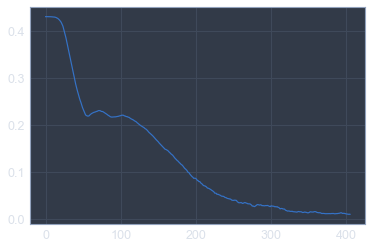

In [12]:

plt.plot(error)
plt.show()


In [13]:
J_est = J_est-np.identity(6)

In [14]:
mean_squared_error(J_est,J)

0.0002746071615378763

In [15]:
mean_squared_error(C_est,C)

0.00024812602427525183

--------------------------------------------
# Plot network


In [16]:
labels =  list(range(N))

G = nx.from_numpy_matrix(J)

G = nx.relabel_nodes(G,lambda x: labels[x])

G.edges(data=True)


EdgeDataView([(0, 1, {'weight': 0.040711313501175274}), (0, 3, {'weight': 0.213019107825933}), (0, 4, {'weight': 0.24699003125353122}), (1, 3, {'weight': 0.03651737497910039}), (2, 5, {'weight': 0.2052597334521189}), (3, 5, {'weight': 0.28801942272280784}), (4, 5, {'weight': 0.034335298817656734})])

In [35]:
def plot_network(connections):
    labels =  list(range(len(connections)))
    G = nx.from_numpy_matrix(connections)
    G = nx.relabel_nodes(G,lambda x: labels[x])
    G.edges(data=True)

    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #positions
    positions=nx.circular_layout(G)    
    #Figure size
    plt.figure(figsize=(8,8))
    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#FEB335',
                           node_size=500)    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,width = 4, edge_color ='#0699e5')    
    # displays the graph without axis
    plt.axis('off')   

    plt.show() 

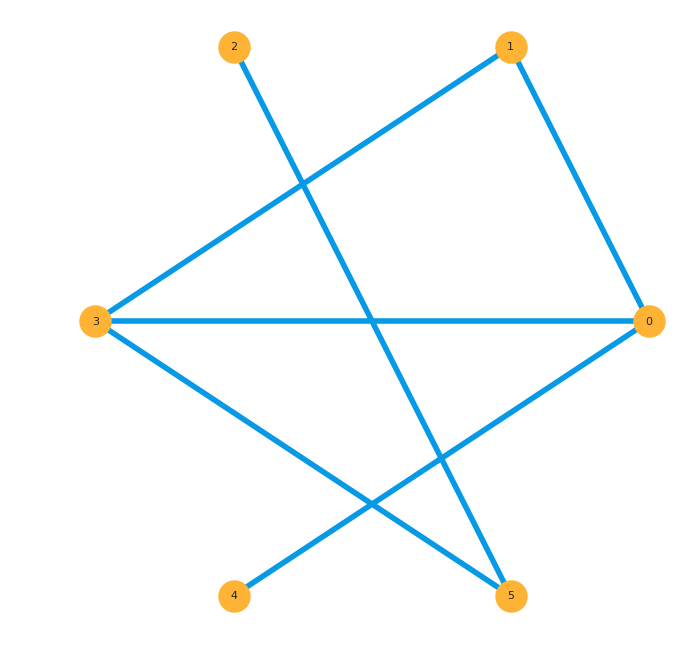

In [36]:
plot_network(np.around(J_est,2))


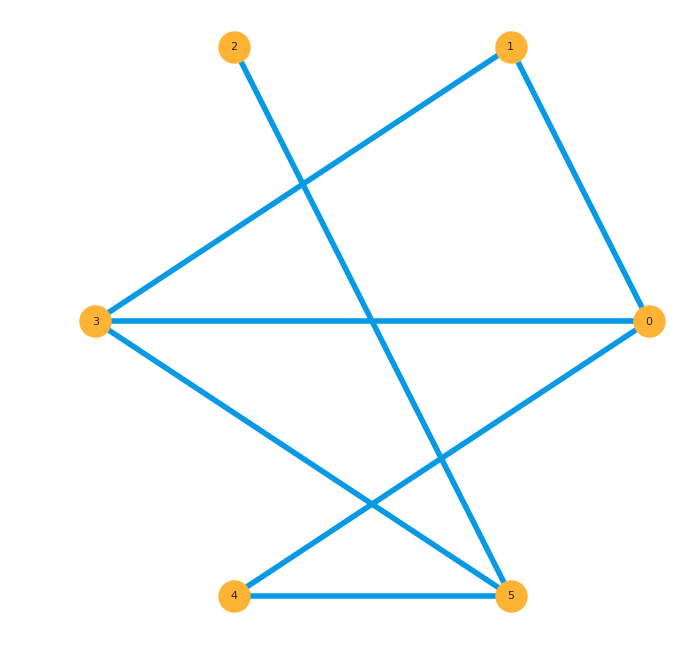

In [37]:

plot_network(J)
